<a href="https://colab.research.google.com/github/xRetry/FPS_RPM_Analysis/blob/main/PYMC3_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FPS vs RPM - A Bayesian Analysis

## 1. Introduction

In this analysis I am looking at data that has been collected in various tests, regarding the influence of four different predictors on the fire rate in Planetside 2. To achieve this, I am implementing a Bayesian regression model to describe the observed data. As a result, it is possible to see whether or not a certain predictor does really have an influence on the fire rate, as well as the amount of its influence.

## 2. Predictors and Response

The predictors were mostly chosen based on the suggestions in [this](https://www.reddit.com/r/Planetside/comments/hzcoxz/fps_vs_rpm_an_empirical_analysis_all_credit_goes/) Reddit post and are the following:

*   In-game frame rate
*   Ideal fire rate of a weapon
*   "Render Quality" setting in-game
*   Different ways of fps limiting or no limiter at all

In order to detach the measured from the ideal fire rate, I chose as response variable the decrease of fire rate (percentage of ideal), not the fire rate itself.

## 3. Data Collection

The used data includes the results of every test I could find on the internet, as well as all the data points from personally performed tests.

### 3.1. Personally performed Tests

My own testing was done in VR Training. I recorded the time it took to empty a magazine with ShadowPlay at 60fps. From the start and end frame of every mag-dump, I calculated the resulting fire rate and then the resulting decrease in fire rate. For every test, I wrote down the corresponding predictors.

Due to the overlap of recording and in-game frame rate, I calculated the resulting measurement error.

### 3.2. Data from other Sources

For the data collected from the internet, some assumptions had to be made, since the exact testing process and accuracy was mostly unclear. 
For one, the render quality was assumed to be set to 1 if not stated otherwise. Furthermore, in order to estimate the measurement errors, I assumed a variation of the in-game frame rate of +/- 3fps during testing, as well as a time measuring error of +/- 1s.

### 3.3. Quality of Data

Since the testing process is very time-consuming and the achievable measurement accuracy poor, the overall quality of the data is not great. The number of data points for certain predictors is very low and some of the tests even had somewhat contradicting results. This makes the process of finding a robust model to describe the data not easy.

## 4. Model Selection

This section might be a bit technical. I am trying to keep it as simple as possible and won't go into too much detail.

In general, I am using a Bayesian multilevel model. Since one of the main ideas is to also capture the uncertainty given the bad data, a Bayesian model fits this requirement perfectly. Furthermore, I am representing the different limiter types using a multilevel structure, with one hyperparameter for each coefficient.

### 4.1. Linear Model

As a baseline, I used a linear relationship between the predictors and response,


> $decrease = intercept + b_{fps} * fps + b_{rpm} * rpm + b_{rq} * rq + error$



where $intercept$ is the offset from zero, $fps$, $rpm$, $rq$ are the predictors and $b_{fps}$, $b_{rpm}$, $b_{rq}$ are the coefficients of each predictor. The model error $error$ contains the measurement error for the decrease in fire rate, as well as the initially unknown model error. 

To describe what happens simply, the model is trying to find the best values for the coefficients to fit the measured decrease. Therefore, coefficients directly represent the influence of each predictor. If it is zero there is none and the further away from zero it is, the bigger the influence.


### 4.2. Exponential Model

How well a model can describe the observed data greatly depends on the type of model chosen. A model that uses a linear relationship, for example, will be pretty inaccurate when it is trying to describe exponential data. On the flip side, a very complex model might be able to describe every datapoint perfectly well but completely fails to capture the actual underlying relationship (known as overfitting). Therefore, the model choice has to be approached carefully.

In this case, specifically, the relationship between frame rate and decrease looks like it might be exponential, though this could also be a side effect of inaccurate data. To be sure, I am using a second model that includes this exponential relationship and comparison will show if it performs significantly better.

> $decrease = intercept + b_{fps_1} * e^{-b_{fps_2} * fps} + b_{rpm} * rpm + b_{rq} * rq + error$


## 5. Implementation
I am not going to explain much here, since going into every detail would go beyond the scope of this analysis.

### 5.1. Data Preparation

In [ ]:
### Installing compatible versions
#!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4

In [4]:
### Importing necessary libraries
import pandas as pd
import seaborn as sb
import pymc3 as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import xarray as xa
import warnings
# seed for reproducability
np.random.seed(123)
plt.style.use('arviz-darkgrid')

In [6]:
### Loading and preparing old data
oldData = pd.read_csv('data_old.csv')

fps_error = 3 * np.ones(len(oldData['FPS']))  # assume +-3fps during measuring
time_error = 1  # assume a time recording error of +-1s
times = 1 / ((1 - oldData['Decrease']) * oldData['IdealRPM'] / 60)  * oldData['MagSize'] # calculate measured times from decrease
oldData['FpsError'] = 2 * fps_error / np.sqrt(12) # convert fps error range to standard deviation
oldData['DecreaseError'] = 2 * ((60 * oldData['MagSize']) / (oldData['IdealRPM'] * times**2)) * time_error / np.sqrt(12) # calculate error propagation
del oldData['MagSize']
oldDataLbls = oldData.copy() # copy dataframe
oldDataLbls['LimiterType'] = oldDataLbls['LimiterType'].map({0:'None', 1:'MaximumFPS', 2:'RTSS', 3:'Smoothing'}) # replace numbers for limiter types with names

In [7]:
### Loading and preparing new data (own testing)
newDataLbls = pd.read_csv('data_new.csv')
del newDataLbls['Unnamed: 0']
newDataLbls['FpsError'] = 2 * newDataLbls['FpsError'] / np.sqrt(12)  # convert fps error range to standard deviation
newDataLbls['DecreaseError'] = 2 * newDataLbls['DecreaseError'] / np.sqrt(12)  # convert decrease error range to standard deviation
newData = newDataLbls.copy() # copy dataframe
limT_labels = {'None':0, 'MaximumFPS':1, 'RTSS':2, 'Smoothing':3}
newData['LimiterType'] = newData['LimiterType'].map(limT_labels) # replace numbers for limiter types with names
# combine both dataframes
fullData = pd.concat([oldData, newData])
fullDataLbls = pd.concat([oldDataLbls, newDataLbls])

limT = fullData['LimiterType'].unique() # extract numbers for limiter types
fullData

FPS  IdealRPM  Decrease  RenQual  LimiterType  FpsError  DecreaseError
0     30.0     500.0  0.206000      1.0            2  1.732051       0.030332
1    210.0     500.0  0.026000      1.0            2  1.732051       0.045643
2     30.0     577.0  0.211438      1.0            2  1.732051       0.046033
3    210.0     577.0  0.024263      1.0            2  1.732051       0.070480
4     30.0     600.0  0.231667      1.0            2  1.732051       0.034083
..     ...       ...       ...      ...          ...       ...            ...
605   90.0     600.0  0.029126      0.9            3  1.732051       0.044832
606   90.0     600.0  0.032258      0.9            3  1.732051       0.044831
607   90.0     600.0  0.025974      0.9            3  1.732051       0.044833
608   90.0     600.0  0.025974      0.9            3  1.732051       0.044833
609   90.0     600.0  0.029126      0.9            3  1.732051       0.044832

[654 rows x 7 columns]

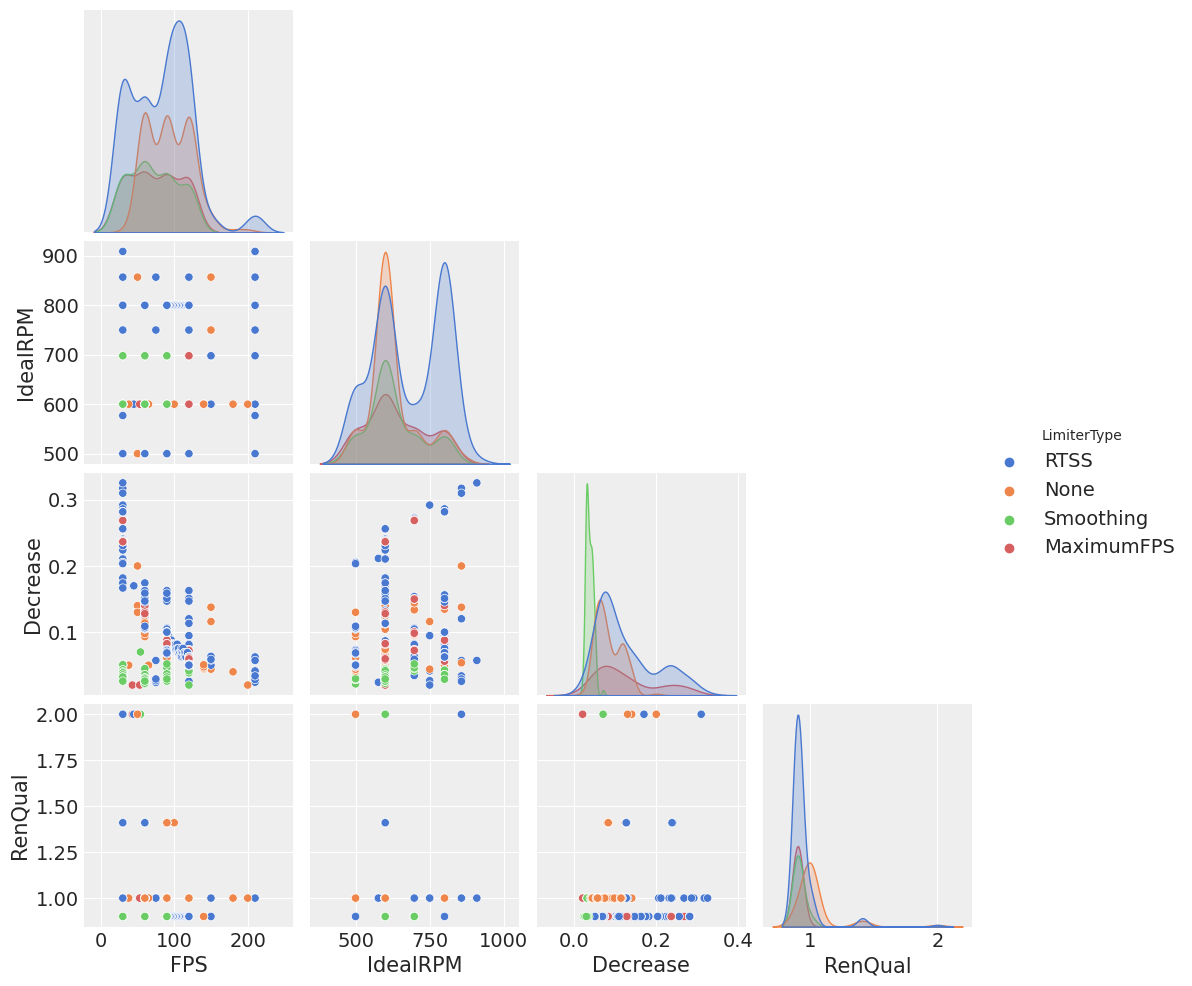

In [ ]:
### Visualizing data
_ = sb.pairplot(fullDataLbls, hue='LimiterType',vars=['FPS', 'IdealRPM',	'Decrease',	'RenQual'] , palette='muted', corner=True)

When looking at the visualization of the datapoints, there are two things that become apparent:

*   The amount of data is really poor for some predictors.
*   The frame rate - decrease relationship looks like it might be exponential. Due to the measurement errors, which are not included in this visualization, it is hard to tell for sure though.



### 5.2. Linear Model

In [ ]:
### Defining the linear model
with pm.Model() as linModel:
    # hyperpriors for limiter types
    mu_a = pm.Normal('mu_intercept', mu=0., sigma=10)
    sigma_a = pm.HalfNormal('sigma_intercept', 5.)

    mu_b1 = pm.Normal('mu_b_fps', mu=0., sigma=0.1)
    sigma_b1 = pm.HalfNormal('sigma_b_fps', 0.05)

    mu_b2 = pm.Normal('mu_b_rpm', mu=0., sigma=0.1)
    sigma_b2 = pm.HalfNormal('sigma_b_rpm', 0.05)

    mu_b3 = pm.Normal('mu_b_rq', mu=0., sigma=10)
    sigma_b3 = pm.HalfNormal('sigma_b_rq', 5.)

    # non centered parameterization
    a_offset = pm.Normal('a_offset', mu=0, sd=1, shape=len(limT))
    a = pm.Deterministic("intercept", mu_a + a_offset * sigma_a)

    b1_offset = pm.Normal('fps_offset', mu=0, sd=1, shape=len(limT))
    b1 = pm.Deterministic("b_fps", mu_b1 + b1_offset * sigma_b1)

    b2_offset = pm.Normal('rpm_offset', mu=0, sd=1, shape=len(limT))
    b2 = pm.Deterministic("b_rpm", mu_b2 + b2_offset * sigma_b2)

    b3_offset = pm.Normal('rq_offset', mu=0, sd=1, shape=len(limT))
    b3 = pm.Deterministic("b_rq", mu_b3 + b3_offset * sigma_b3)

    # error model
    fps_true = pm.Normal('mu_fps', mu=75, sigma=10., shape=len(fullData['FPS'])); # prior for (unknown) true fps values during testing
    fps_obs = pm.Normal('fps_error', mu=fps_true, sd=fullData['FpsError'].values, observed=fullData['FPS']) # error for variation of frame rate during testing

    eps = pm.HalfCauchy('error', 5.) # prior for otherwise unaccounted error

    # predictor - response realtionship
    dec_true = pm.Deterministic('dec_true',\
      a[fullData['LimiterType'].values] + \
      b1[fullData['LimiterType'].values] * fps_true + \
      b2[fullData['LimiterType'].values] * fullData['IdealRPM'].values + \
      b3[fullData['LimiterType'].values] * fullData['RenQual'].values)

    # prior for degrees of freedom of t-distribution
    #nu = pm.InverseGamma("nu", alpha=1, beta=1)
    nu = pm.Gamma('nu', 2, 0.1)

    # response (likelihood)
    dec_obs = pm.StudentT('dec_obs', mu=dec_true, sd=fullData['DecreaseError'].values + eps, nu=nu, observed=fullData['Decrease'])

In [ ]:
### Sampling from model
with linModel:
    linTrace = pm.sample(2000, tune=2000, target_accept=.90, max_treedepth=12)#, init="adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [nu, error, mu_fps, rq_offset, rpm_offset, fps_offset, a_offset, sigma_b_rq, mu_b_rq, sigma_b_rpm, mu_b_rpm, sigma_b_fps, mu_b_fps, sigma_intercept, mu_intercept]
Sampling chain 1, 3 divergences: 100%|██████████| 4000/4000 [27:10<00:00,  2.45it/s]
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.


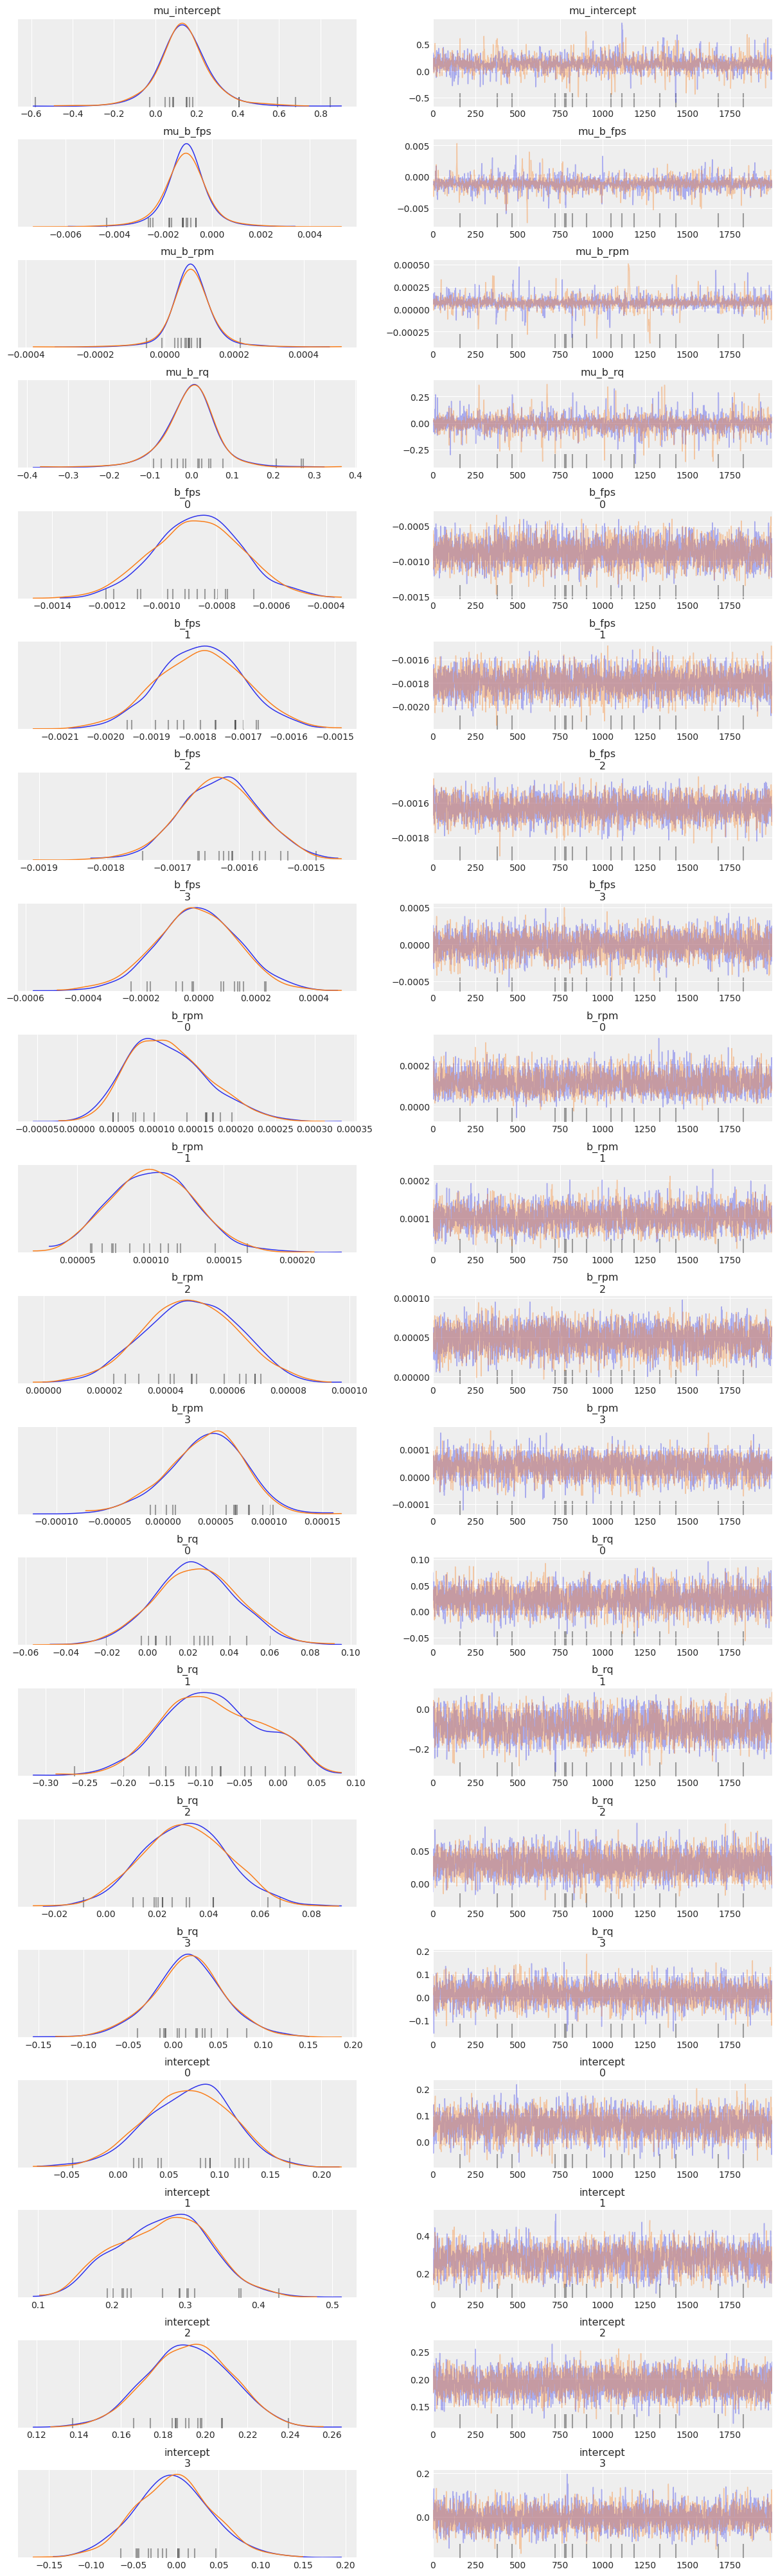

In [ ]:
### Visualizing traces
warnings.filterwarnings('ignore')
_ = az.plot_trace(linTrace, var_names=['mu_intercept', 'mu_b_fps', 'mu_b_rpm', 'mu_b_rq', 'b_fps', 'b_rpm', 'b_rq', 'intercept'])

The trace plots look ok. No issues there.

In [ ]:
### Sampling summary
pm.summary(linTrace, var_names=['mu_intercept', 'mu_b_fps', 'mu_b_rpm', 'mu_b_rq', 'b_fps', 'b_rpm', 'b_rq', 'intercept'])

mean     sd  hpd_3%  hpd_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
mu_intercept  0.134  0.130  -0.122    0.370  ...  1107.0    1592.0    1593.0    1.0
mu_b_fps     -0.001  0.001  -0.003    0.001  ...  1804.0    2127.0    1896.0    1.0
mu_b_rpm      0.000  0.000  -0.000    0.000  ...   824.0    1488.0    1140.0    1.0
mu_b_rq      -0.003  0.069  -0.146    0.114  ...  1626.0    2525.0    2059.0    1.0
b_fps[0]     -0.001  0.000  -0.001   -0.001  ...  4092.0    4085.0    3808.0    1.0
b_fps[1]     -0.002  0.000  -0.002   -0.002  ...  3659.0    3652.0    3644.0    1.0
b_fps[2]     -0.002  0.000  -0.002   -0.002  ...  3491.0    3600.0    3022.0    1.0
b_fps[3]     -0.000  0.000  -0.000    0.000  ...  2720.0    3703.0    3198.0    1.0
b_rpm[0]      0.000  0.000   0.000    0.000  ...  3118.0    2958.0    3567.0    1.0
b_rpm[1]      0.000  0.000   0.000    0.000  ...  2837.0    2757.0    2880.0    1.0
b_rpm[2]      0.000  0.000   0.000    0.000  ...  3773.0    3998.0    3405.0    1.0
b_rpm[3]      0.000  0.000  -0.000    0.000  ...  3355.0    4085.0    3604.0    1.0
b_rq[0]       0.024  0.020  -0.013    0.063  ...  3681.0    3673.0    3353.0    1.0
b_rq[1]      -0.083  0.064  -0.192    0.035  ...  1722.0    1755.0    2149.0    1.0
b_rq[2]       0.031  0.017   0.001    0.062  ...  4144.0    4129.0    3623.0    1.0
b_rq[3]       0.016  0.040  -0.063    0.092  ...  2785.0    4954.0    3133.0    1.0
intercept[0]  0.069  0.042  -0.011    0.145  ...  3061.0    3291.0    3366.0    1.0
intercept[1]  0.269  0.062   0.150    0.373  ...  1860.0    1883.0    2523.0    1.0
intercept[2]  0.192  0.020   0.158    0.230  ...  4217.0    4221.0    3595.0    1.0
intercept[3] -0.004  0.045  -0.088    0.080  ...  2654.0    5017.0    3184.0    1.0

[20 rows x 11 columns]

R-hat values look also ok.

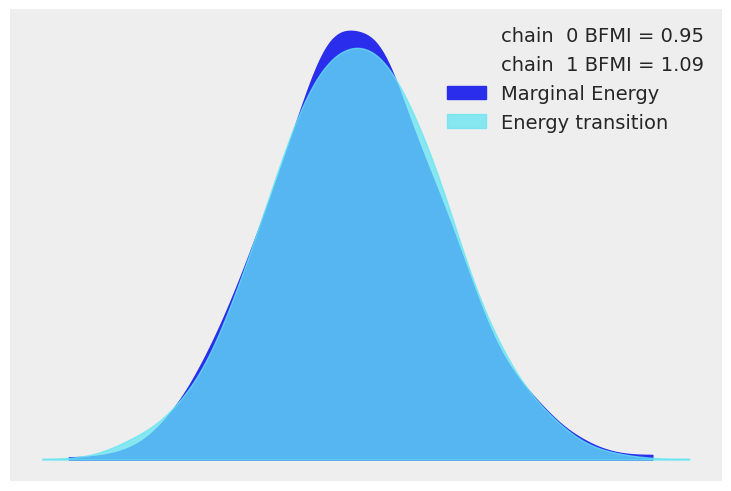

In [ ]:
### Energy comparision
_ = pm.energyplot(linTrace)

The energy distributions are overlapping very well, indicating good exploration of parameter space.

Overall, the sampling seems to have worked decently well.

In [ ]:
### Generating posterior predictive samples 
ppc_lin = pm.sample_posterior_predictive(linTrace, model=linModel, var_names=['b_fps', 'b_rpm', 'b_rq', 'intercept', 'dec_obs', 'dec_true'], keep_size=True)

100%|██████████| 4000/4000 [00:13<00:00, 299.52it/s]


In [ ]:
### Converting sampling data to InferenceData
linData = az.from_pymc3(linTrace, posterior_predictive=ppc_lin, model=linModel)

In [ ]:
### Saving data
linData.to_netcdf('drive/MyDrive/Colab Notebooks/LinModelData_norm')

'drive/MyDrive/Colab Notebooks/LinModelData_norm'

### 5.3. Exponential Model

In [ ]:
### Defining the exponential model
with pm.Model() as expModel:
    # hyperpriors for limiter types
    mu_a = pm.Normal('mu_intercept', mu=0., sigma=10)
    sigma_a = pm.HalfNormal('sigma_intercept', 5.)

    mu_b1_1 = pm.Normal('mu_b_fps_1', mu=0., sigma=10)
    sigma_b1_1 = pm.HalfNormal('sigma_b_fps_1', 5.)

    mu_b1_2 = pm.Lognormal('mu_b_fps_2', mu=0., sigma=1)
    sigma_b1_2 = pm.HalfNormal('sigma_b_fps_2', 0.5)

    mu_b2 = pm.Normal('mu_b_rpm', mu=0., sigma=0.1)
    sigma_b2 = pm.HalfNormal('sigma_b_rpm', 0.05)

    mu_b3 = pm.Normal('mu_b_rq', mu=0., sigma=10)
    sigma_b3 = pm.HalfNormal('sigma_b_rq', 5.)

    # non centered parameterization
    a_offset = pm.Normal('a_offset', mu=0, sd=1, shape=len(limT))
    a = pm.Deterministic("intercept", mu_a + a_offset * sigma_a)

    b1_1_offset = pm.Normal('fps_1_offset', mu=0, sd=1, shape=len(limT))
    b1_1 = pm.Deterministic("b_fps_1", mu_b1_1 + b1_1_offset * sigma_b1_1)

    b1_2 = pm.Lognormal('b_fps_2', mu=mu_b1_2, sigma=sigma_b1_2, shape=len(limT)) # centered for exponent

    b2_offset = pm.Normal('rpm_offset', mu=0, sd=1, shape=len(limT))
    b2 = pm.Deterministic("b_rpm", mu_b2 + b2_offset * sigma_b2)

    b3_offset = pm.Normal('rq_offset', mu=0, sd=1, shape=len(limT))
    b3 = pm.Deterministic("b_rq", mu_b3 + b3_offset * sigma_b3)
   
    # model error
    fps_true = pm.Normal('mu_fps', mu=75, sigma=10., shape=len(fullData['FPS'])); # prior for (unknown) true fps values during testing
    fps_obs = pm.Normal('fps_error', mu=fps_true, sd=fullData['FpsError'].values, observed=fullData['FPS'])  # error for variation of frame rate during testing

    eps = pm.HalfCauchy('error', 5.)
    
    # predictor - response realtionship
    dec_true = pm.Deterministic('dec_true', \
      a[fullData['LimiterType'].values] + \
      b1_1[fullData['LimiterType'].values] * np.exp(-b1_2[fullData['LimiterType'].values] * fps_true) + \
      b2[fullData['LimiterType'].values] * fullData['IdealRPM'].values + \
      b3[fullData['LimiterType'].values] * fullData['RenQual'].values)

    # prior for degrees of freedom of t-distribution
    nu = pm.Gamma('nu', 2, 0.1)

    # response (likelihood)
    dec_like = pm.StudentT('dec_obs', mu=dec_true, sigma=fullData['DecreaseError'].values+eps, nu=nu, observed=fullData['Decrease'])

In [ ]:
### Sampling from model
with expModel:
    expTrace = pm.sample(4000, tune=3000, chains=2, target_accept=0.99, init="adapt_diag", max_treedepth=12)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [nu, error, mu_fps, rq_offset, rpm_offset, b_fps_2, fps_1_offset, a_offset, sigma_b_rq, mu_b_rq, sigma_b_rpm, mu_b_rpm, sigma_b_fps_2, mu_b_fps_2, sigma_b_fps_1, mu_b_fps_1, sigma_intercept, mu_intercept]
Sampling chain 1, 1 divergences: 100%|██████████| 6000/6000 [1:38:31<00:00,  1.01it/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9702202140714569, but should be close to 0.99. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


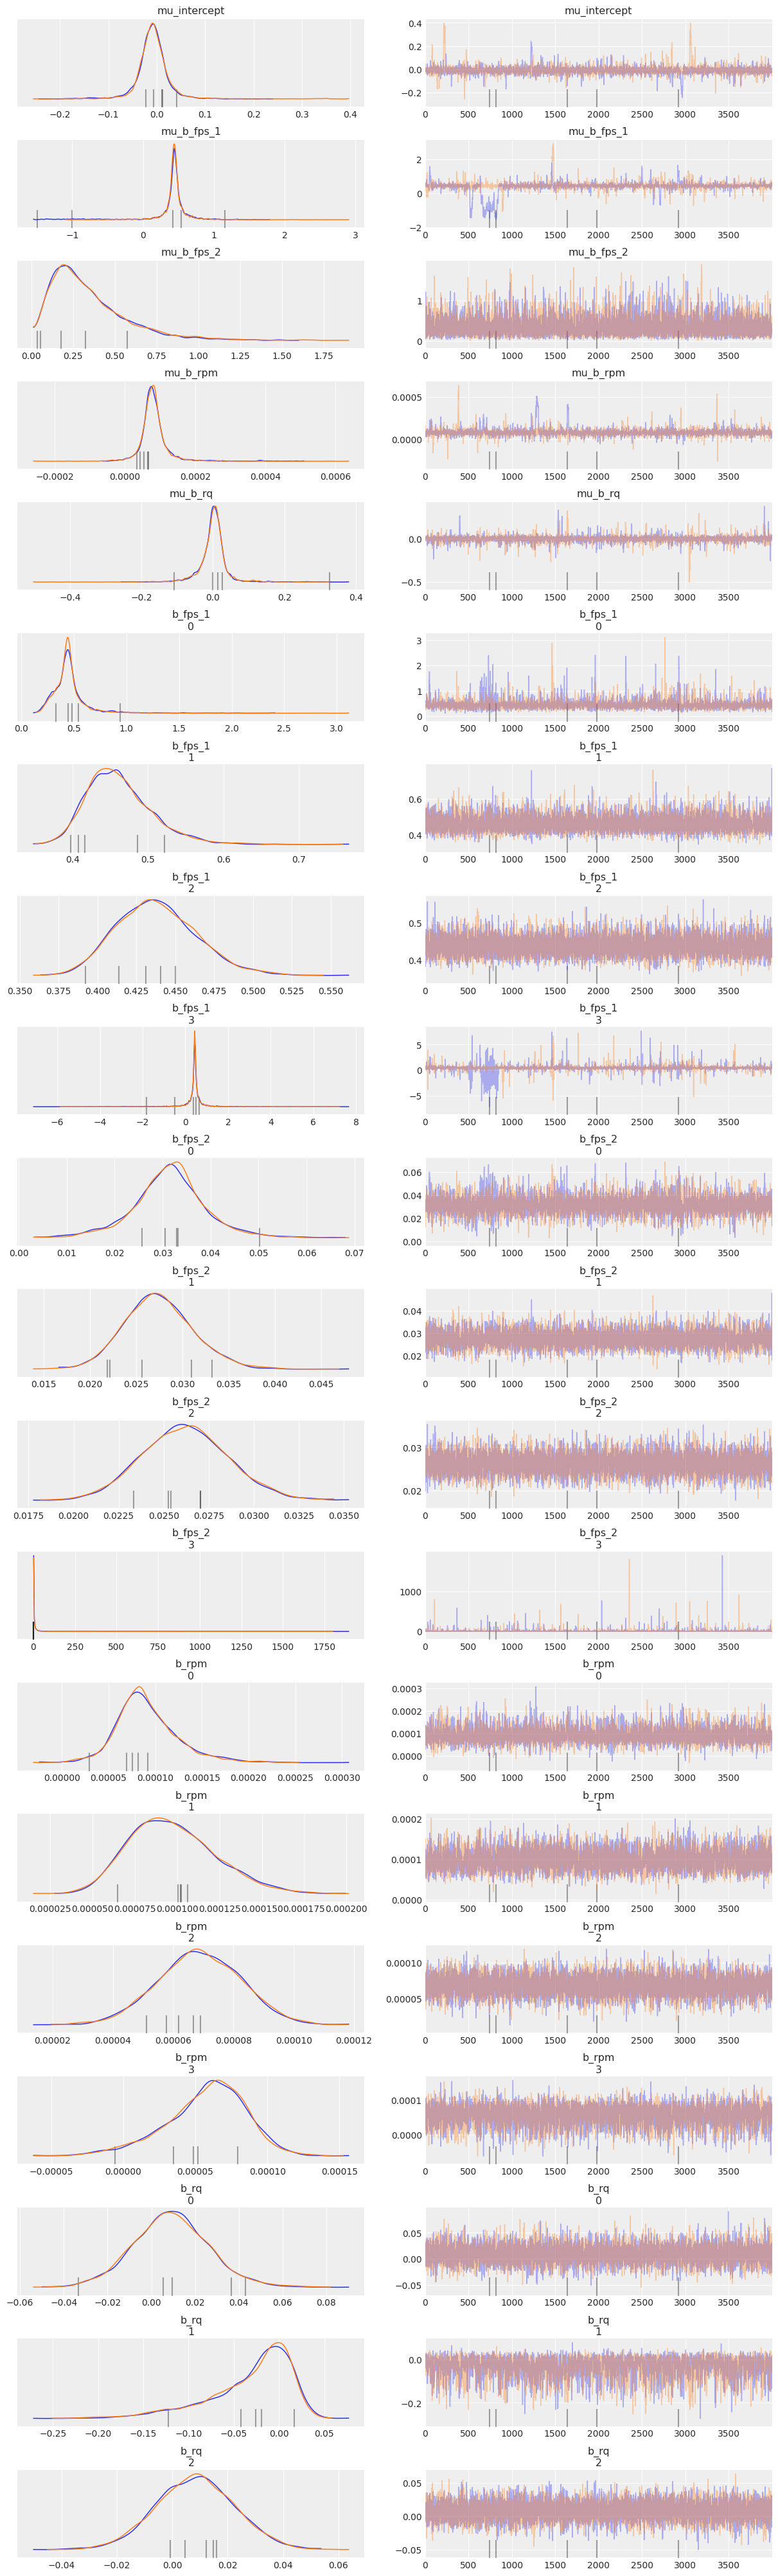

In [ ]:
### Visualizing traces
warnings.filterwarnings('ignore')
_ = az.plot_trace(expTrace, var_names=['mu_intercept', 'mu_b_fps_1', 'mu_b_fps_2', 'mu_b_rpm', 'mu_b_rq', 'b_fps_1', 'b_fps_2', 'b_rpm', 'b_rq', 'intercept'])

In [ ]:
### Sampling summary
pm.summary(expTrace, var_names=['mu_intercept', 'mu_b_fps_1', 'mu_b_fps_2', 'mu_b_rpm', 'mu_b_rq', 'b_fps_1', 'b_fps_2', 'b_rpm', 'b_rq', 'intercept'])

mean      sd  hdi_3%  ...  ess_bulk  ess_tail  r_hat
mu_intercept -0.007   0.039  -0.070  ...    2271.0    1566.0   1.00
mu_b_fps_1    0.414   0.303  -0.005  ...     256.0      65.0   1.01
mu_b_fps_2    0.344   0.235   0.023  ...   11025.0    5598.0   1.00
mu_b_rpm      0.000   0.000   0.000  ...    1951.0     921.0   1.00
mu_b_rq       0.000   0.041  -0.078  ...    3206.0    2028.0   1.00
b_fps_1[0]    0.452   0.174   0.180  ...    4639.0    3891.0   1.00
b_fps_1[1]    0.462   0.043   0.391  ...    8614.0    6805.0   1.00
b_fps_1[2]    0.438   0.026   0.391  ...   10803.0    6256.0   1.00
b_fps_1[3]    0.425   0.614  -0.460  ...    1014.0     159.0   1.01
b_fps_2[0]    0.031   0.008   0.015  ...    4509.0    2588.0   1.00
b_fps_2[1]    0.027   0.004   0.021  ...    8640.0    5357.0   1.00
b_fps_2[2]    0.026   0.002   0.022  ...   12933.0    6214.0   1.00
b_fps_2[3]    9.264  46.825   0.034  ...    8996.0    5704.0   1.00
b_rpm[0]      0.000   0.000   0.000  ...    5381.0    4871.0   1.00
b_rpm[1]      0.000   0.000   0.000  ...    3865.0    6349.0   1.00
b_rpm[2]      0.000   0.000   0.000  ...    7872.0    7047.0   1.00
b_rpm[3]      0.000   0.000   0.000  ...    5443.0    6844.0   1.00
b_rq[0]       0.009   0.017  -0.023  ...    8805.0    6997.0   1.00
b_rq[1]      -0.031   0.047  -0.128  ...    1729.0    3052.0   1.00
b_rq[2]       0.008   0.014  -0.019  ...    8733.0    7056.0   1.00
b_rq[3]       0.010   0.025  -0.038  ...    7796.0    4644.0   1.00
intercept[0] -0.018   0.029  -0.073  ...    4072.0    2298.0   1.00
intercept[1]  0.007   0.040  -0.059  ...    2405.0    3079.0   1.00
intercept[2] -0.009   0.017  -0.039  ...    9196.0    7139.0   1.00
intercept[3] -0.011   0.026  -0.063  ...    9060.0    4881.0   1.00

[25 rows x 11 columns]

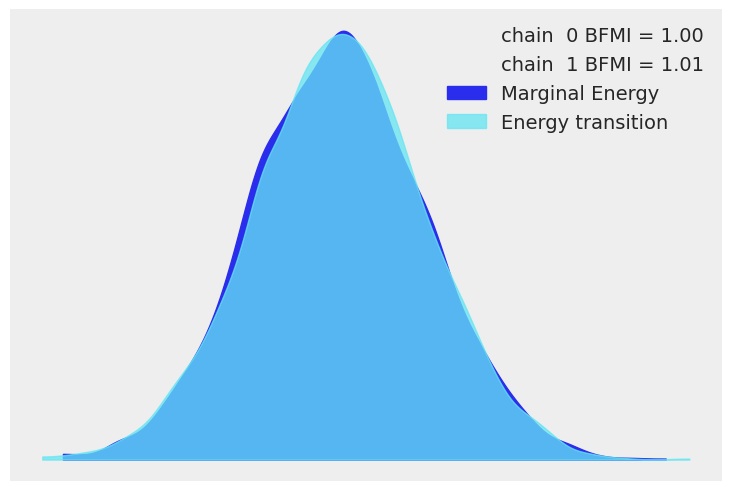

In [ ]:
### Energy comparision
_ = pm.energyplot(expTrace)

In [ ]:
### Generating posterior predictive samples 
ppc_exp = pm.sample_posterior_predictive(expTrace, model=expModel, var_names=['b_fps_1', 'b_fps_2', 'b_rpm', 'b_rq', 'intercept', 'dec_obs', 'dec_true'], keep_size=True)

100%|██████████| 8000/8000 [00:25<00:00, 310.35it/s]


In [ ]:
### Converting sampling data to InferenceData
expData = az.from_pymc3(expTrace, posterior_predictive=ppc_exp, model=expModel)

In [ ]:
### Saving data
expData.to_netcdf('drive/MyDrive/Colab Notebooks/ExpModelData_norm')

'drive/MyDrive/Colab Notebooks/ExpModelData_norm'

### 5.4. Model Comparison

Now that both models have been successfully created, it is time to compare them.

In [10]:
### Loading saved model data
linData = az.from_netcdf('drive/MyDrive/Colab Notebooks/LinModelData_norm')
expData = az.from_netcdf('drive/MyDrive/Colab Notebooks/ExpModelData_norm')

Text(0.5, 1.0, 'Exponential Model')

/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


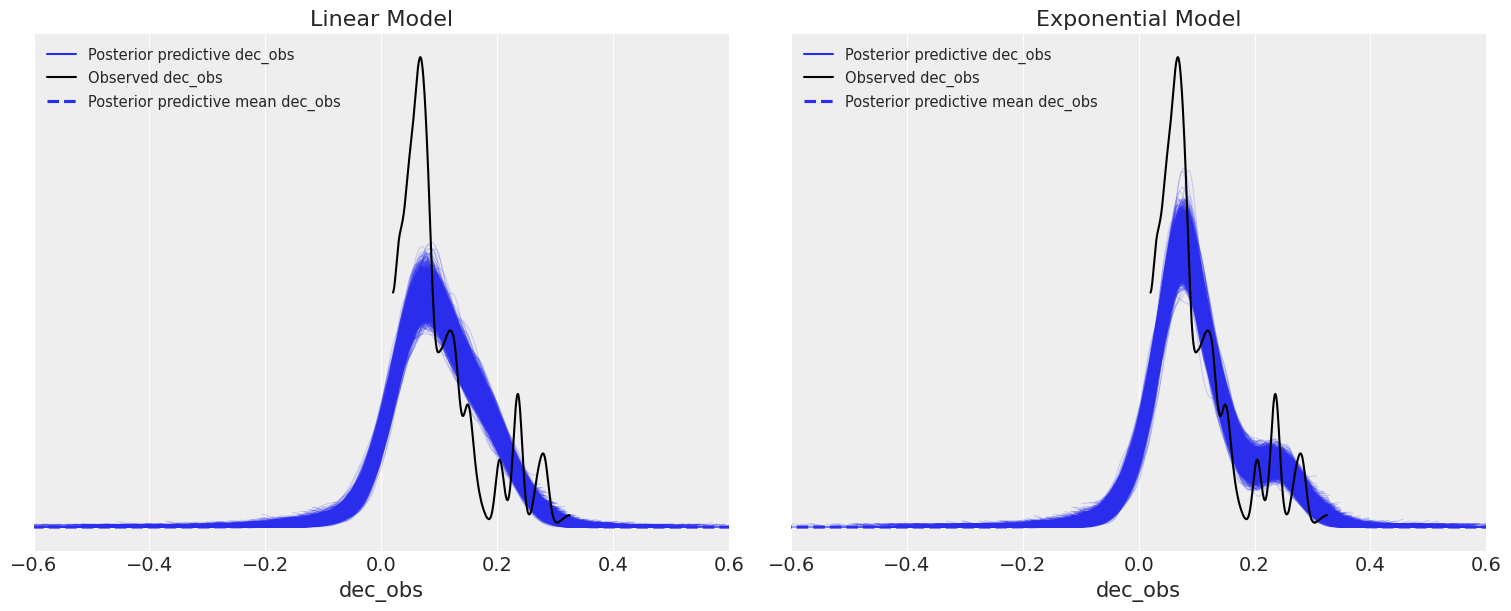

In [ ]:
### Posterior predictive check
fig, axs = plt.subplots(1, 2, figsize=(15,6))
az.plot_ppc(linData, var_names='dec_obs', ax=axs[0])
axs[0].set_xlim([-0.6, 0.6])
axs[0].set_title('Linear Model')
az.plot_ppc(expData, var_names='dec_obs', ax=axs[1])
axs[1].set_xlim([-0.6, 0.6])
axs[1].set_title('Exponential Model')

Looking at the posterior predictive plots, although both models aren't fully describing the data, the exponential model does a slightly better job.

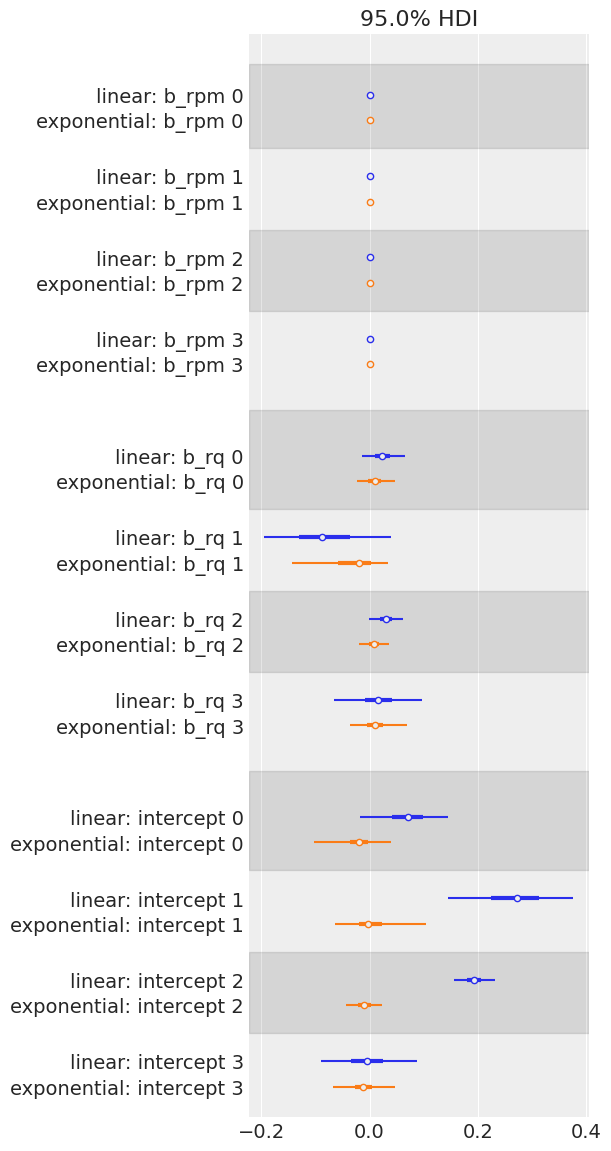

In [ ]:
### Coefficient Overview
_ = az.plot_forest([linData, expData], var_names=['b_rpm', 'b_rq', 'intercept'], model_names=['linear', 'exponential'], hdi_prob=0.95, combined=True, )

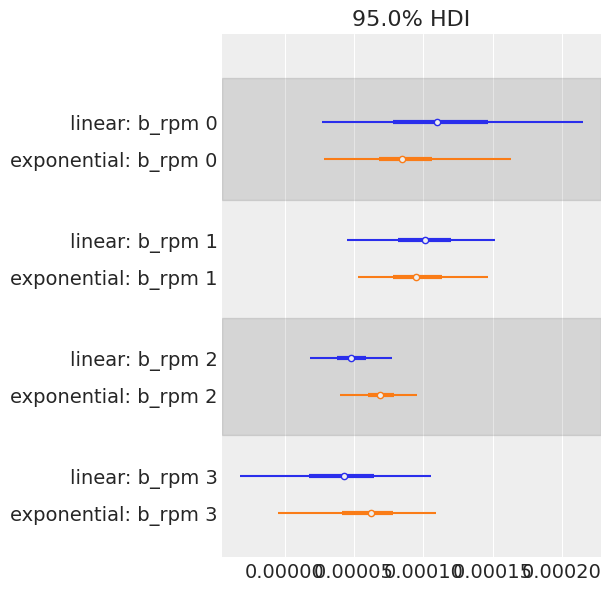

In [ ]:
### RPM coefficients in detail
_ = az.plot_forest([linData, expData], var_names='b_rpm', model_names=['linear', 'exponential'], hdi_prob=0.95, combined=True)

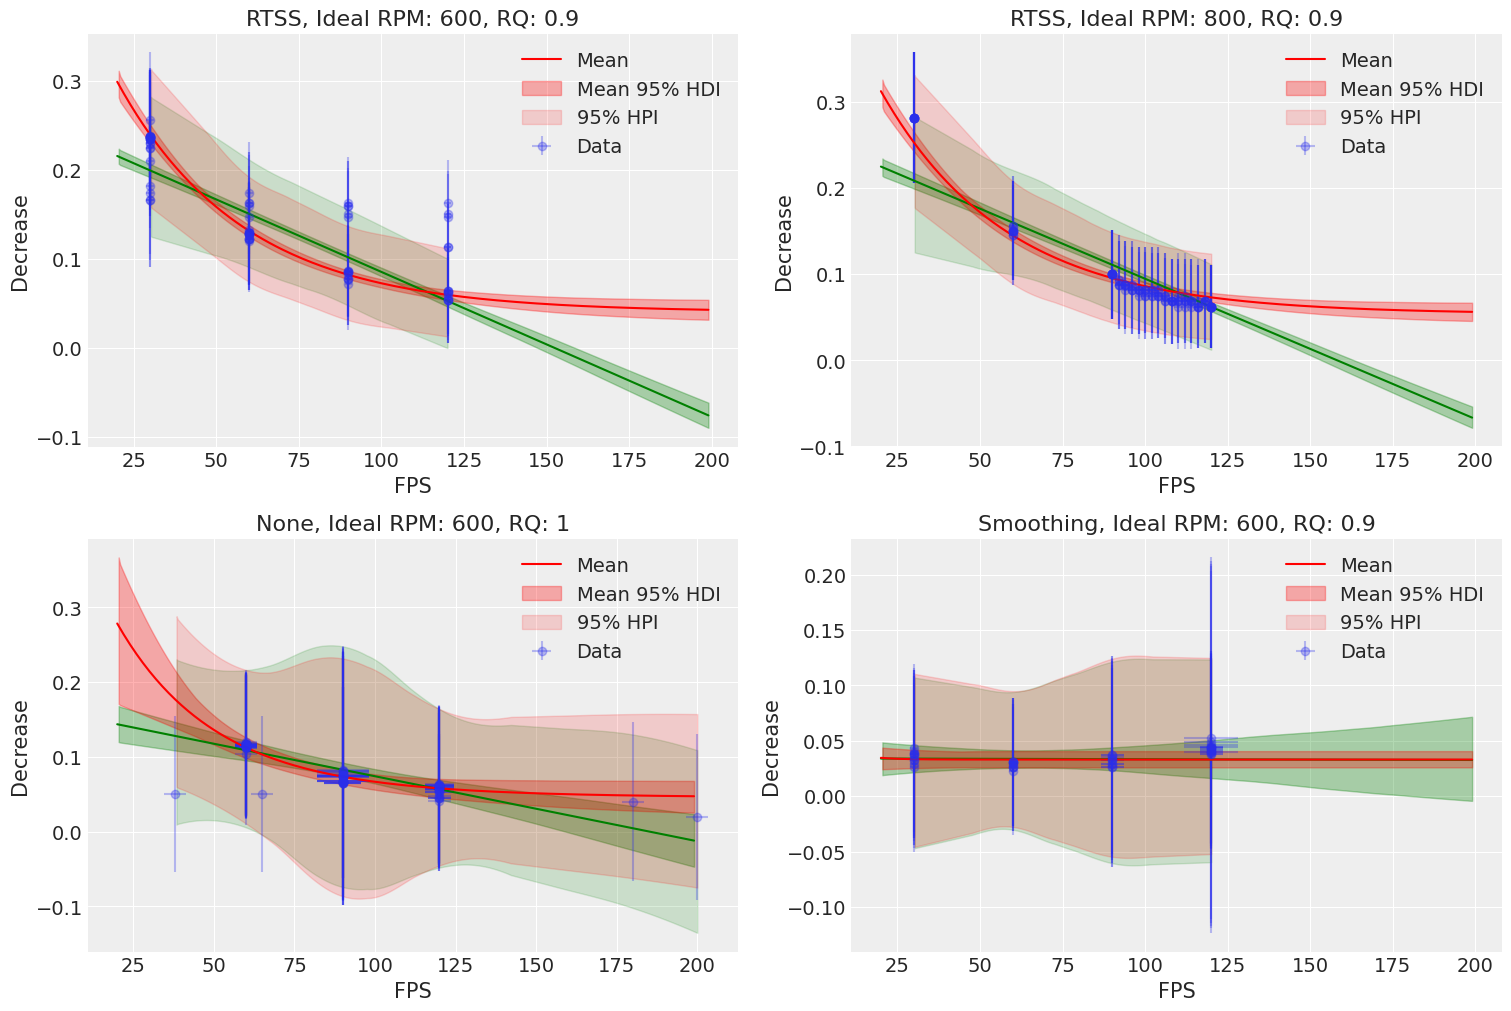

In [22]:
### Comparing with specific parameters
warnings.simplefilter(action='ignore', category=FutureWarning)
def linFun(fps, rpm, rq, limT):
  a = linData.posterior_predictive['intercept'].values.reshape(4000, 4)[:, limT]
  b_fps = linData.posterior_predictive['b_fps'].values.reshape(4000, 4)[:, limT]
  b_rpm = linData.posterior_predictive['b_rpm'].values.reshape(4000, 4)[:, limT]
  b_rq = linData.posterior_predictive['b_rq'].values.reshape(4000, 4)[:, limT]
  return a +\
  b_fps * fps[:, None] +\
  b_rpm * rpm[:, None] +\
  b_rq * rq[:, None]

def expFun(fps, rpm, rq, limT):
  n = expData.posterior_predictive['intercept'].shape[0] * expData.posterior_predictive['intercept'].shape[1]
  a = expData.posterior_predictive['intercept'].values.reshape(n, 4)[:, limT]
  b_fps_1 = expData.posterior_predictive['b_fps_1'].values.reshape(n, 4)[:, limT]
  b_fps_2 = expData.posterior_predictive['b_fps_2'].values.reshape(n, 4)[:, limT]
  b_rpm = expData.posterior_predictive['b_rpm'].values.reshape(n, 4)[:, limT]
  b_rq = expData.posterior_predictive['b_rq'].values.reshape(n, 4)[:, limT]
  return a +\
  b_fps_1 * np.exp(-b_fps_2 * fps[:, None]) +\
  b_rpm * rpm[:, None] +\
  b_rq * rq[:, None]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
limTs = [2, 2, 0, 3]
rpms = [600, 800, 600, 600]
rqs = [0.9, 0.9, 1, 0.9]

for i, a in enumerate(axs):
  for j, ax in enumerate(a):

    limT = limTs[j + len(a)*(i)]
    rpm = rpms[j + len(a)*(i)]
    rq = rqs[j + len(a)*(i)]
    fpsVals = np.arange(20, 200, 1)

    decVals_lin = linFun(
        fps=fpsVals, 
        rpm=np.ones_like(fpsVals)*rpm, 
        rq=np.ones_like(fpsVals)*rq,
        limT=limT)

    decVals_exp = expFun(
        fps=fpsVals, 
        rpm=np.ones_like(fpsVals)*rpm, 
        rq=np.ones_like(fpsVals)*rq,
        limT=limT)

    filter = (fullData['LimiterType'] == limT) & (fullData['IdealRPM'] == rpm) & (fullData['RenQual'] == rq)

    ax.errorbar(fullData[filter]['FPS'], fullData[filter]['Decrease'], 
                yerr=fullData[filter]['DecreaseError'] *2, xerr=fullData[filter]['FpsError'] *2, 
                alpha=0.3, marker='o', ls='', label='Data')
    ax.plot(fpsVals, decVals_lin.T.mean(0), color='g')
    ax.plot(fpsVals, decVals_exp.T.mean(0), color='r', label='Mean')
    az.plot_hdi(fpsVals, decVals_lin.T, 
                color='g', ax=ax, hdi_prob=0.95, fill_kwargs={'alpha':0.3})
    az.plot_hdi(fpsVals, decVals_exp.T, 
                color='r', ax=ax, hdi_prob=0.95, fill_kwargs={'alpha':0.3, "label": "Mean 95% HDI"})
    az.plot_hdi(fullData[filter]['FPS'], linData.posterior_predictive['dec_obs'][:,:,filter],
                color='g', ax=ax, hdi_prob=0.95, fill_kwargs={'alpha':0.15})
    az.plot_hdi(fullData[filter]['FPS'], expData.posterior_predictive['dec_obs'][:,:,filter],
                color='r', ax=ax, hdi_prob=0.95, fill_kwargs={'alpha':0.15, "label": "95% HPI"})
    ax.set_title(list(limT_labels.keys())[list(limT_labels.values()).index(limT)] + ', Ideal RPM: ' + str(rpm) + ', RQ: ' + str(rq))
    ax.set_xlabel('FPS')
    ax.set_ylabel('Decrease')
    ax.legend()
plt.show()

Comparing both models with actual data, the shortcomings of the linear model become obvious. For certain parameters it predicts no decrease over 150fps, which is not the case in reality. Therefore, the exponential model offers way better prediction abilities. The linear model will be disregarded.

## 6. Findings

The direct comparison shows, that a model with an exponential relationship between frame rate and fire rate describes the data best. The remaining predictors are modeled linearly.

The number next to each coefficient name represents the different ways of limiting the frame rate and are indexed as follows:

    0: no limiter used
    1: MaximiumFPS setting
    2: RTSS
    3: Smoothing

### 6.1. Posterior Distributions
A closer look at the individual predictor coefficients shows their influence on the decrease of fire rate. Each coefficient has its own probability distribution associated with it. These distributions not only show the most likely location of the true coefficient values but also its uncertainty.

The 95% HDI (highest density interval) is showing the range in which the true value lies, with 95% probability. Therefore, whenever the HDI is not crossing zero, the corresponding predictor has a statistically significant influence on the response (the probability that there is no influence regardless is smaller than 5%). The HDI crossing zero, on the other hand, does not necessarily mean that the corresponding predictor has no influence, the data available might not be enough to show it.

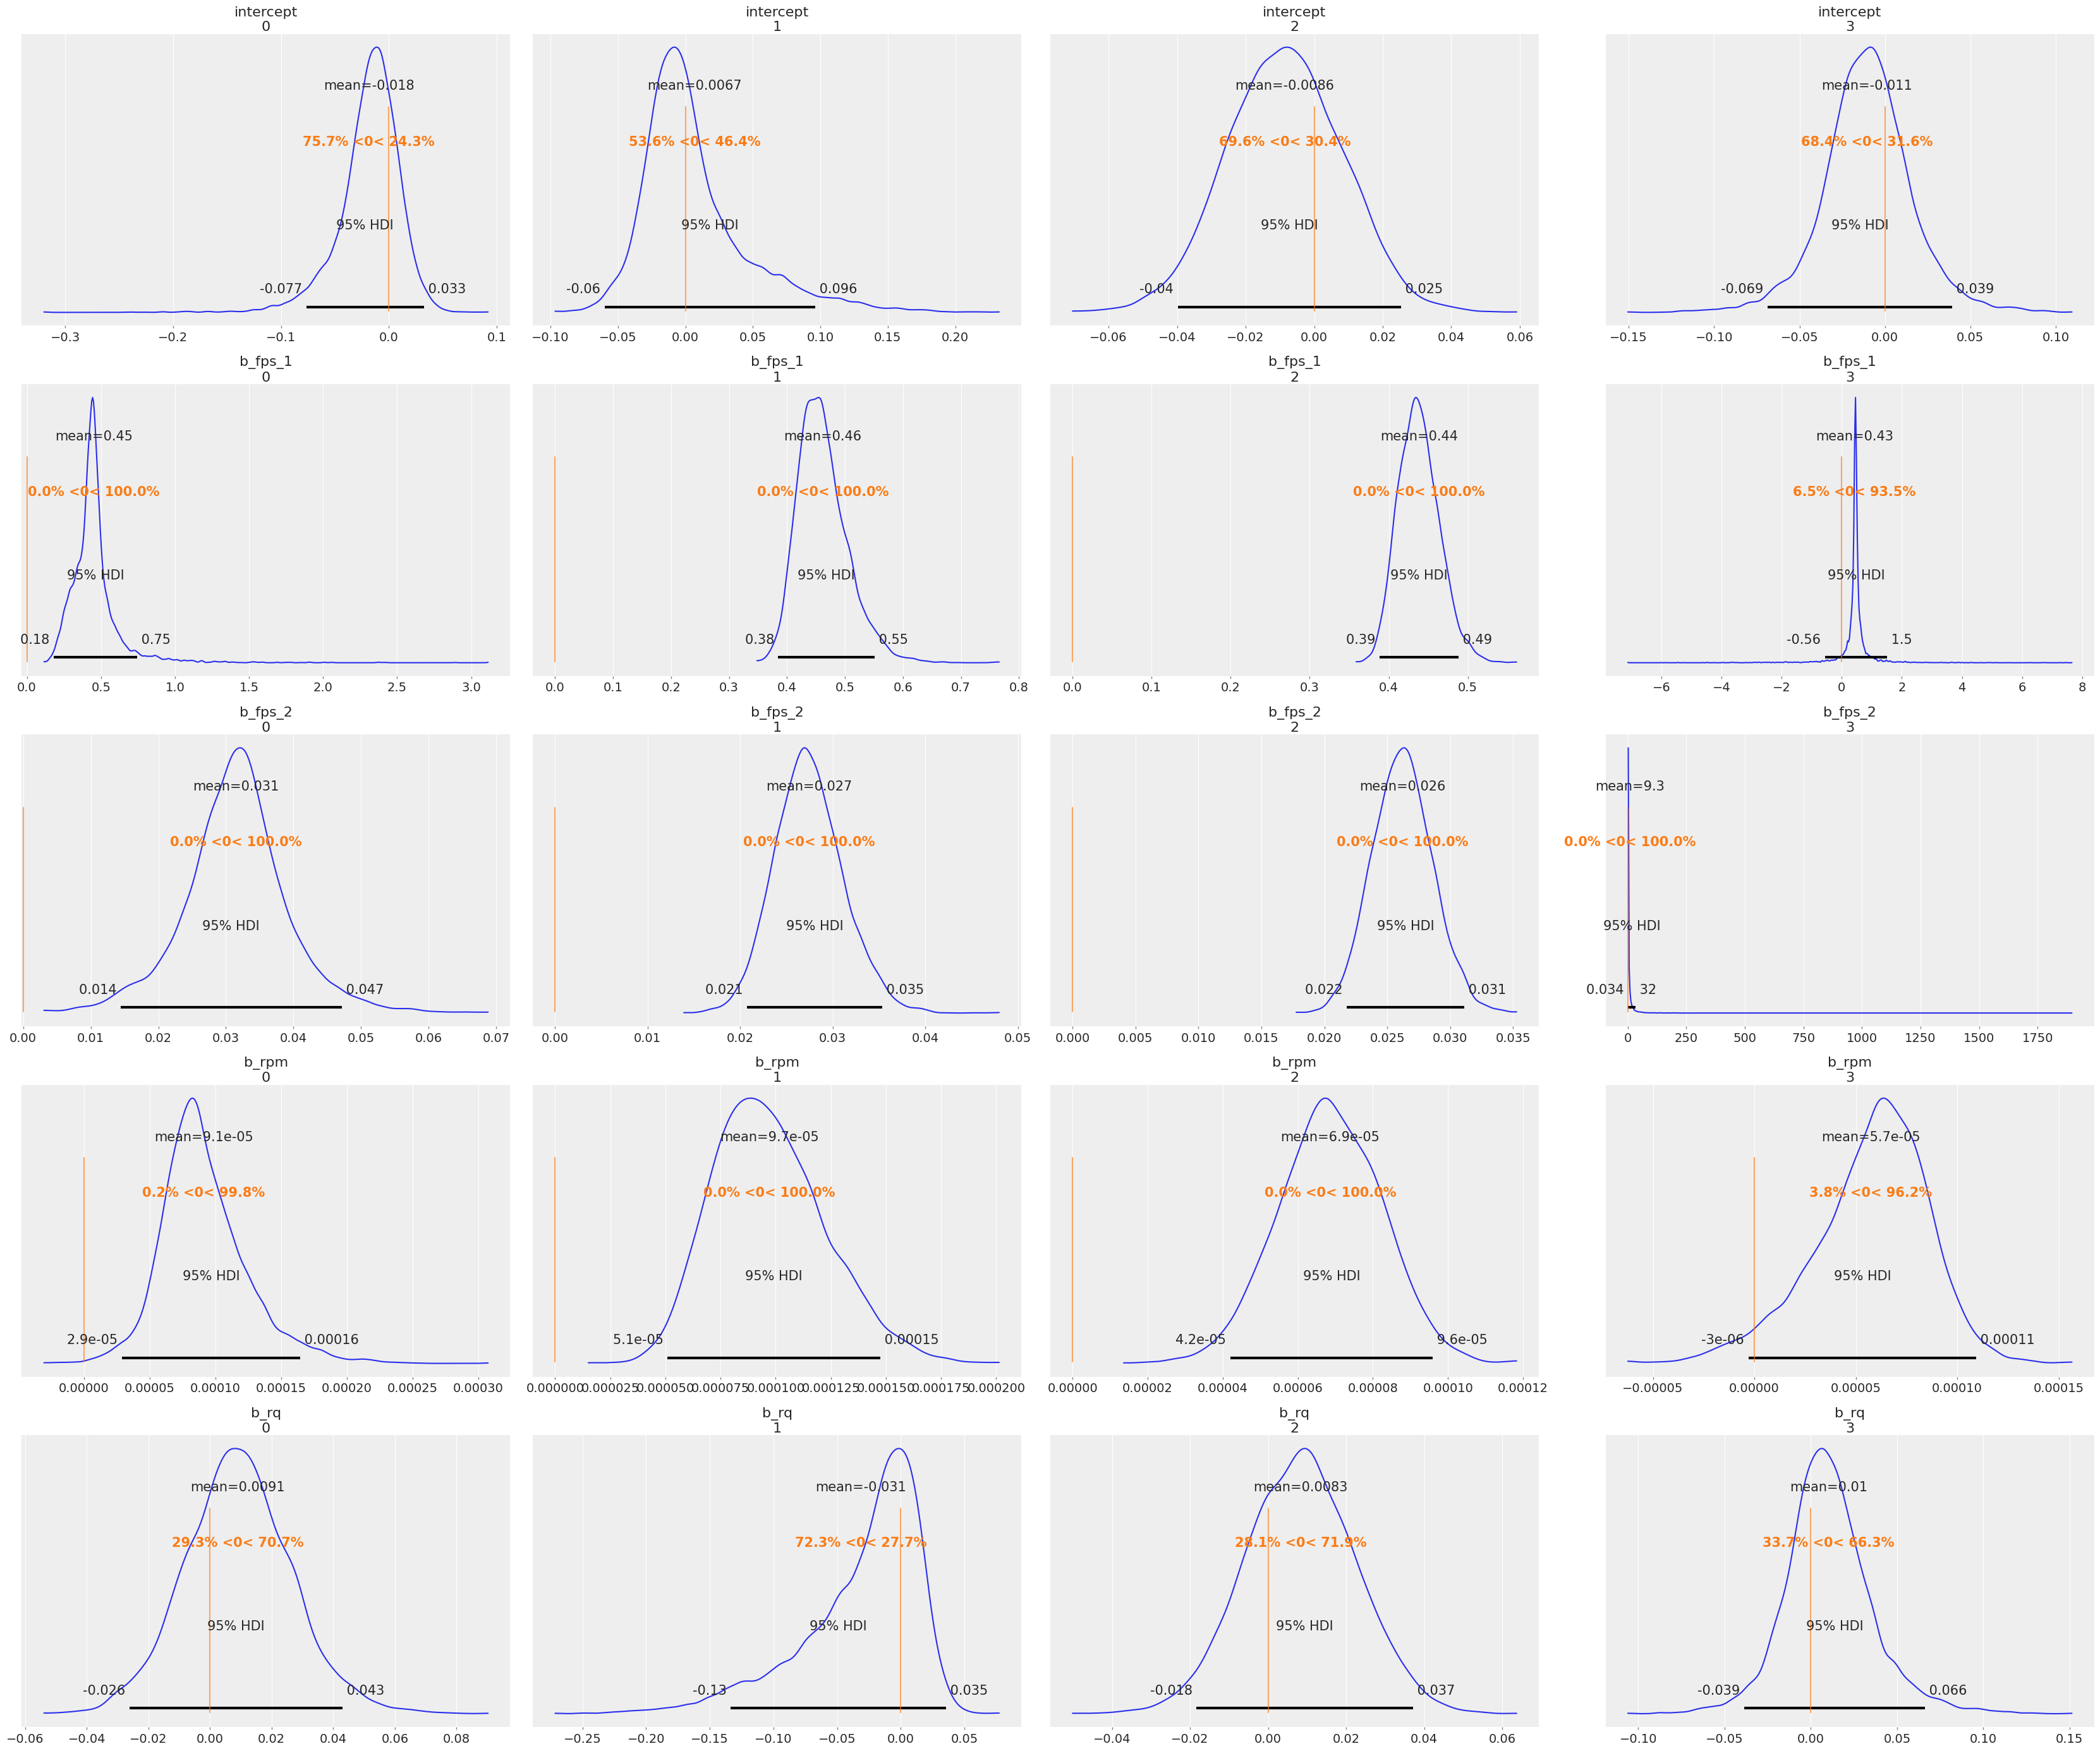

In [ ]:
### Visualizing posterior distributions
_ = az.plot_posterior(expData, var_names=['intercept', 'b_fps_1', 'b_fps_2', 'b_rpm', 'b_rq'], ref_val=0, hdi_prob=0.95)

The posterior distributions of the predictor coefficients are showing the following:
*   The render quality does not show a statistically significant influence on the decrease of fire rate.
*   When using "Smoothing" no influence in any of the predictors can be observed.





The next graph is showing the same distributions but as a direct comparison between the different ways of limiting the frame rate.

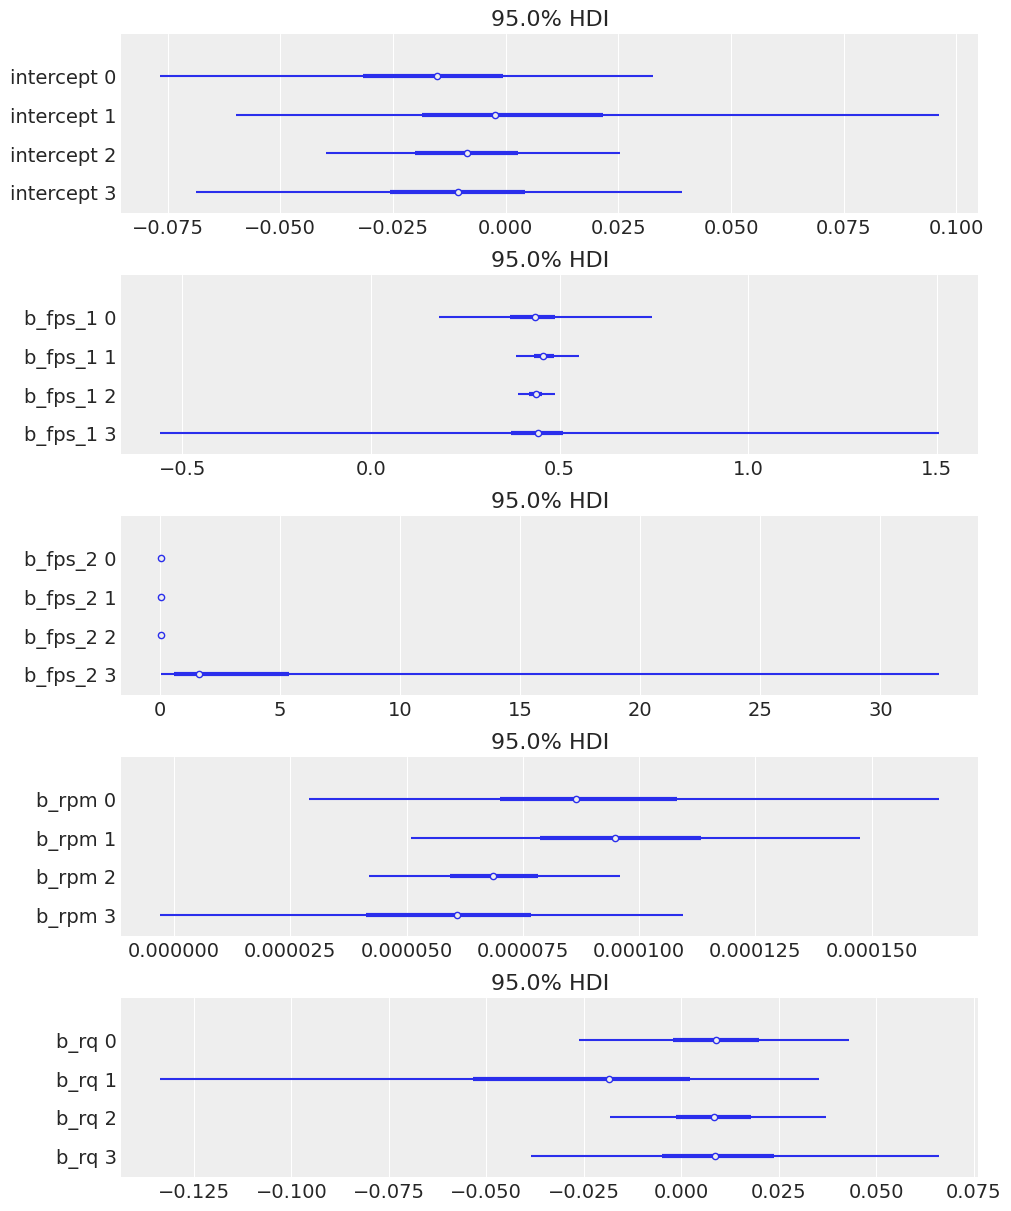

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(10, 12))
_ = az.plot_forest(expData, var_names=['intercept'], combined=True, quartiles=True, hdi_prob=0.95, ax=axs[0])
_ = az.plot_forest(expData, var_names=['b_fps_1'], combined=True, quartiles=True, hdi_prob=0.95, ax=axs[1])
_ = az.plot_forest(expData, var_names=['b_fps_2'], combined=True, quartiles=True, hdi_prob=0.95, ax=axs[2])
_ = az.plot_forest(expData, var_names=['b_rpm'], combined=True, quartiles=True, hdi_prob=0.95, ax=axs[3])
_ = az.plot_forest(expData, var_names=['b_rq'], combined=True, quartiles=True, hdi_prob=0.95, ax=axs[4])


This comparison is showing no significant difference between the limiter types, except for Smoothing.

### 6.2. Resulting Relationship Function

The mean values of the posterior distributions can now be used to construct the whole relationship function, describing the influence of each predictor on the response.

In the following graph, all statisically insignificant terms have been removed. To make sure the result still offers a good description, it is compared to the full function.

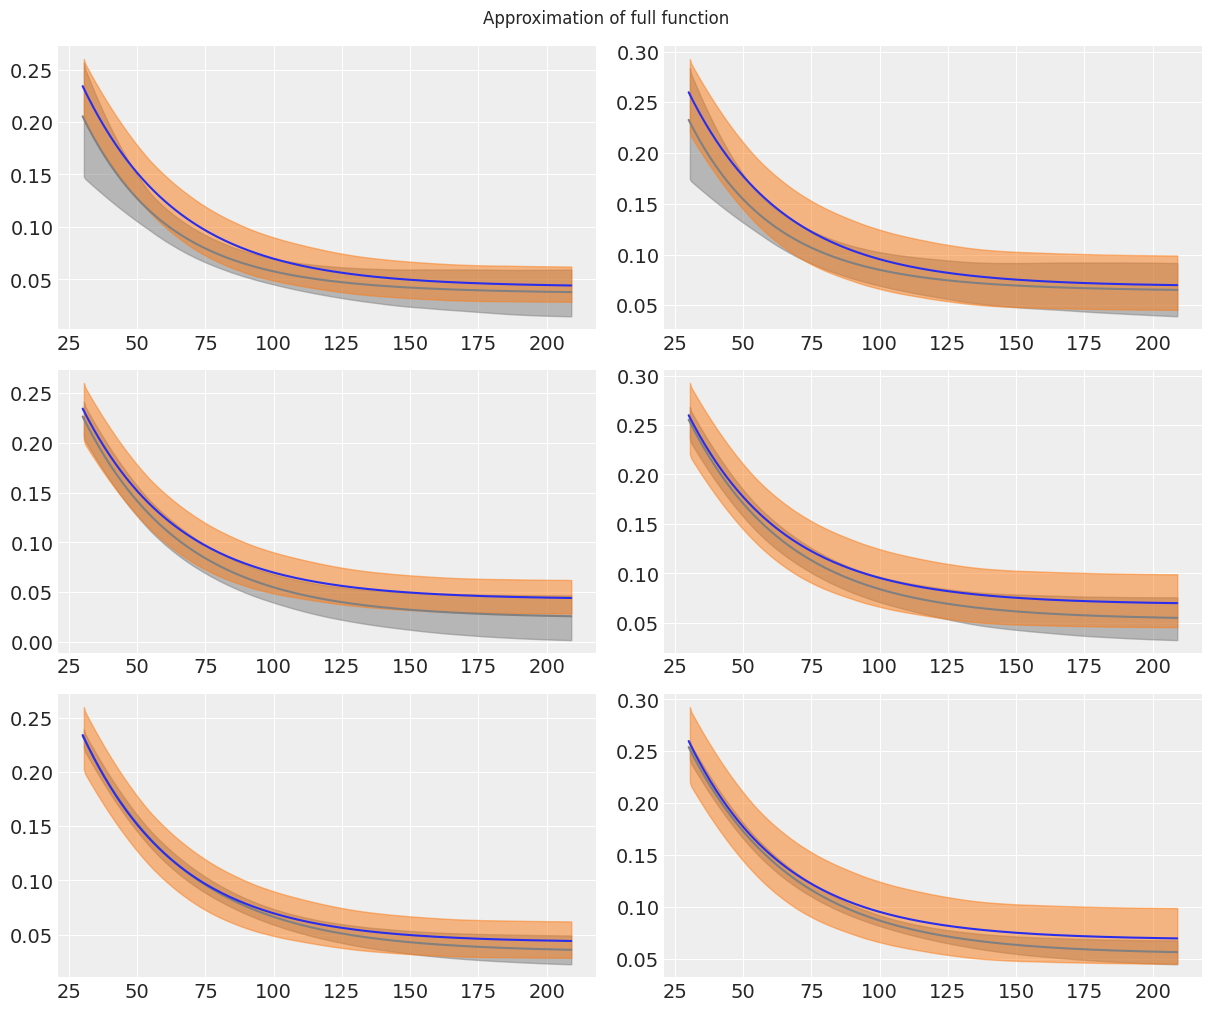

In [124]:
### Relationship function simplification
warnings.simplefilter(action='ignore', category=FutureWarning)
fpsVals = np.arange(30, 210, 1)

# extracting mean values and hdis
def getCoeff(smoothing=None):
  names = ['intercept', 'b_fps_1', 'b_fps_2', 'b_rpm', 'b_rq']
  allVals = []
  for i, n in enumerate(names):
    if smoothing is not None:
      allVals.append(expData.posterior_predictive[n][:, :, 3].values.flatten())
    else:
      allVals.append(expData.posterior_predictive[n][:, :, :3].values.mean(2).flatten())
  return allVals
# plotting graphs
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
for col, r in enumerate([500, 800]):
  # model without render quality 
  allVals = getCoeff()
  d = allVals[1] * np.exp(-allVals[2] * fpsVals[:, None]) + allVals[3] * (np.ones_like(fpsVals)*r)[:, None]
  for lt in range(3):
    # calculating decrease with posterior coefficients
    decVals_exp = expFun(
            fps=fpsVals, 
            rpm=np.ones_like(fpsVals)*r, 
            rq=np.ones_like(fpsVals)*1,
            limT=lt)
    
    az.plot_hdi(fpsVals, decVals_exp.T, ax=axs[lt, col], color='grey', hdi_prob=0.95)
    axs[lt, col].plot(fpsVals, decVals_exp.T.mean(0), c='grey')
    axs[lt, col].plot(fpsVals, d.T.mean(0))
    az.plot_hdi(fpsVals, d.T, ax=axs[lt, col], hdi_prob=0.95)
    fig.suptitle('Approximation of full function')
plt.show()

The simplified function does indeed match the full function very well.

The final simplified formula looks like the following:

In [13]:
print('decrease =', allVals[1].mean(), '* exp('+ str(-allVals[2].mean()), '* fps) +', allVals[3].mean(), '* rpm')
print('Valid for:')
print('Frame Rate:', round(fullData['FPS'].min()), 'to', round(fullData['FPS'].max()), 'fps')
print('Fire Rate:', round(fullData['IdealRPM'].min()), 'to', round(fullData['IdealRPM'].max()), 'rpm')

decrease = 0.45062133140880894 * exp(-0.028360846520557485 * fps) + 8.559964616625598e-05 * rpm
Valid for:
Frame Rate: 30 to 210 fps
Fire Rate: 500 to 909 rpm


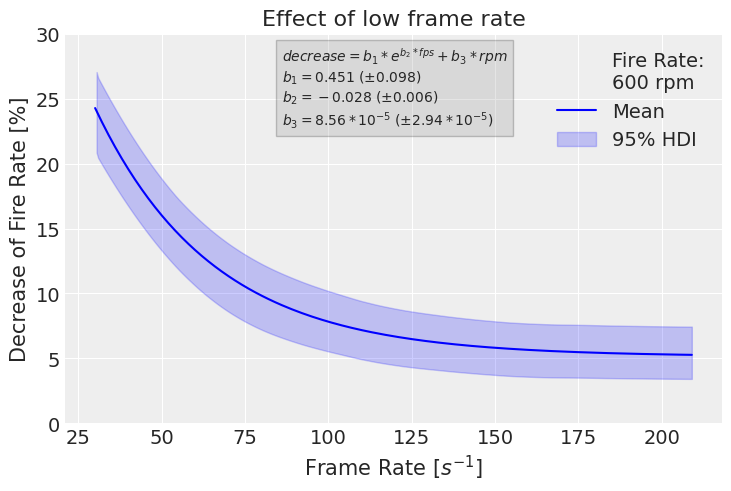

In [173]:
### Visualizing result
fig, ax = plt.subplots()
allVals = getCoeff()
d = allVals[1] * np.exp(-allVals[2] * fpsVals[:, None]) + allVals[3] * (np.ones_like(fpsVals)*600)[:, None]
a1, ax.plot(fpsVals, d.T.mean(0)*100, label='Mean', color='b')
a2 = az.plot_hdi(fpsVals, d.T*100, ax=ax,color='b', hdi_prob=0.95, fill_kwargs={'label':'95% HDI', 'alpha':0.2})
txt = \
'$decrease = b_{1} * e^{b_{2} * fps} + b_{3} * rpm$\n'+\
'$b_{1} = '+str(round(allVals[1].mean(), 3))+'$ $(\pm'+str(round(allVals[1].mean()-az.hdi(allVals[1])[0],3))+')$\n'+ \
'$b_{2} = -'+str(round(allVals[2].mean(), 3))+'$ $(\pm'+str(round(allVals[2].mean()-az.hdi(allVals[2])[0],3))+')$\n'+ \
'$b_{3} = '+"{:.3}".format(allVals[3].mean()*1e5)+'* 10^{-5}$ $(\pm'+"{:.3}".format((allVals[3].mean()-az.hdi(allVals[3])[0])*1e5)+'* 10^{-5})$'
ax.text(86, 23, txt, bbox=dict(facecolor='grey', alpha=0.2))
ax.set_xlabel('Frame Rate [$s^{-1}$]')
ax.set_ylabel('Decrease of Fire Rate [%]')
ax.set_ylim(0, 30)
ax.legend([a2.get_children()[2], a1, a2.get_children()[0]] ,['Fire Rate:\n600 rpm', 'Mean', '95% HDI' ])
ax.set_title('Effect of low frame rate')
plt.show()

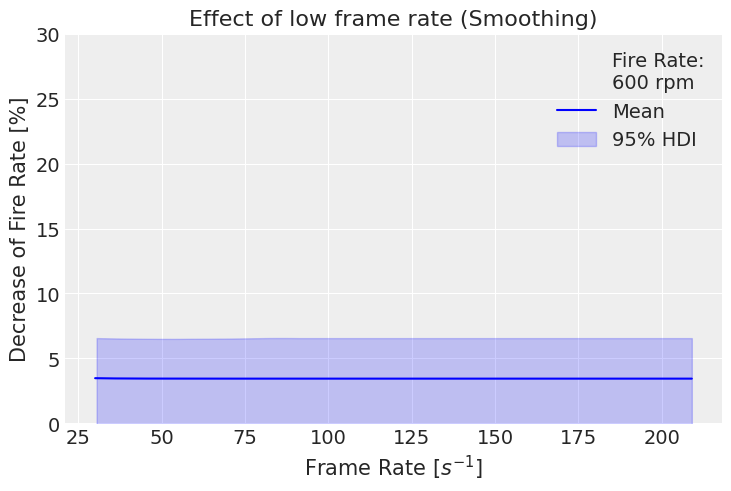

In [171]:
### Visualizing result (smoothing)
fig, ax = plt.subplots()
allVals = getCoeff(smoothing=True)  
d = allVals[1] * np.exp(-allVals[2] * fpsVals[:, None]) + allVals[3] * (np.ones_like(fpsVals)*600)[:, None]
a1, = ax.plot(fpsVals, d.T.mean(0)*100, label='Mean', color='b')
a2 = az.plot_hdi(fpsVals, d.T*100, ax=ax,color='b', hdi_prob=0.95, fill_kwargs={'label':'95% HDI', 'alpha':0.2})
ax.set_xlabel('Frame Rate [$s^{-1}$]')
ax.set_ylabel('Decrease of Fire Rate [%]')
ax.set_ylim(0, 30)
ax.legend([a2.get_children()[2], a1, a2.get_children()[0]] ,['Fire Rate:\n600 rpm', 'Mean', '95% HDI' ])
ax.set_title('Effect of low frame rate (Smoothing)')
plt.show()

### 6.3. Conclusion

The result of this analysis shows, the often-repeated assumptions about the negative impact of low frame rate on the rate of fire are absolutely true. This relationship is also dependent on the ideal fire rate of the weapon. Lower fire rates are less impacted than higher ones.

Contrary to that, this analysis is not showing a statistically significant influence of render quality on the decrease in fire rate.

In regards to limiter types, the only outstanding method of limiting the frame rate is Smoothing. It seems to eliminate all other influences and reduces the decrease to less than 10%, which outperforms even high frame rates. Between the other limiter types, no significant difference could be observed.

Additionally, even though not included in this analysis, tests with vehicle weapons were showing no negative impact of low frame rate on them. They are operating at their ideal fire rate, independent of fps. Furthermore, tests with MAX weapons are showing that they behave the same as other infantry weapons. MAXes are not treated as vehicles in that regard.

### 6.4. Limitations

Even though available external data was included in this analysis, the main part was collected by myself. Therefore, it is possible that the result is biased towards my own hardware and setup. Further analysis is needed to verify the general applicability of these results.

Since the used data spans a certain value range, the model is only expected to offer a good description in this range. Outside of that, model predictions have to be interpreted carefully.

This analysis shows unexpectedly good performance when using Smoothing to limit the frame rate. While this would make it a great choice for players who are not able to achieve a high frame rate, there might be other negative side effect associated with it. Low frame rate in video games is often considered to cause a multitude of issues, further analysis has to be done to verify the effectiveness of Smoothing in Planetside.